<a href="https://colab.research.google.com/github/baloglu321/LLM-s/blob/main/notebooks/unit2/Langraph/Building_Blocks__of_LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

In [2]:
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" I am"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +" happy!"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state": state['graph_state'] +" sad!"}

In [3]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:

    # Often, we will use state to decide on the next node to visit
    user_input = state['graph_state']

    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"

    # 50% of the time, we return Node 3
    return "node_3"

In [4]:
!pip install langgraph

In [5]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

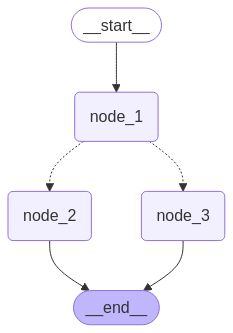

In [6]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
graph.invoke({"graph_state" : "Hi, this is Lance."})

---Node 1---
---Node 2---


{'graph_state': 'Hi, this is Lance. I am happy!'}

In [8]:
!pip install langgraph langchain_openai

In [9]:
import os
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage

In [10]:
class EmailState(TypedDict):
    # The email being processed
    email: Dict[str, Any]  # Contains subject, sender, body, etc.

    # Category of the email
    email_category: Optional[str]

    # Analysis and decisions
    is_spam: Optional[bool]

    # Reason why the email was marked as spam
    spam_reason: Optional[str]

    # Category of the email (inquiry, complaint, etc.)
    email_category: Optional[str]

    # Response generation
    draft_response: Optional[str]

    # Processing metadata
    messages: List[Dict[str, Any]]  # Track conversation with LLM for analysis

In [12]:
import os

import getpass
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API anahtarını gir: ")


OpenAI API anahtarını gir: ··········


In [16]:
# Initialize our LLM
model = ChatOpenAI(temperature=0)

def read_email(state: EmailState):
    """Alfred reads and logs the incoming email"""
    email = state["email"]

    # Here we might do some initial preprocessing
    print(f"Alfred is processing an email from {email['sender']} with subject: {email['subject']}")

    # No state changes needed here
    return {}

def classify_email(state: EmailState):
    """Alfred uses an LLM to determine if the email is spam or legitimate"""
    email = state["email"]

    # Prepare our prompt for the LLM
    prompt = f"""
    As Alfred the butler, analyze this email and determine if it is spam or legitimate.

    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}

    First, determine if this email is spam. If it is spam, explain why.
    If it is legitimate, categorize it (inquiry, complaint, thank you, etc.).
    """

    # Call the LLM
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)

    # Simple logic to parse the response (in a real app, you'd want more robust parsing)
    response_text = response.content.lower()
    is_spam = "spam" in response_text and "not spam" not in response_text

    # Extract a reason if it's spam
    spam_reason = None
    if is_spam and "reason:" in response_text:
        spam_reason = response_text.split("reason:")[1].strip()

    # Determine category if legitimate
    email_category = None
    if not is_spam:
        categories = ["inquiry", "complaint", "thank you", "request", "information"]
        for category in categories:
            if category in response_text:
                email_category = category
                break

    # Update messages for tracking
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]

    # Return state updates
    return {
        "is_spam": is_spam,
        "spam_reason": spam_reason,
        "email_category": email_category,
        "messages": new_messages
    }

def handle_spam(state: EmailState):
    """Alfred discards spam email with a note"""
    print(f"Alfred has marked the email as spam. Reason: {state['spam_reason']}")
    print("The email has been moved to the spam folder.")

    # We're done processing this email
    return {}

def draft_response(state: EmailState):
    """Alfred drafts a preliminary response for legitimate emails"""
    email = state["email"]
    category = state["email_category"] or "general"

    # Prepare our prompt for the LLM
    prompt = f"""
    As Alfred the butler, draft a polite preliminary response to this email.

    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}

    This email has been categorized as: {category}

    Draft a brief, professional response that Mr. Hugg can review and personalize before sending.
    """

    # Call the LLM
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)

    # Update messages for tracking
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]

    # Return state updates
    return {
        "draft_response": response.content,
        "messages": new_messages
    }

def notify_mr_hugg(state: EmailState):
    """Alfred notifies Mr. Hugg about the email and presents the draft response"""
    email = state["email"]

    print("\n" + "="*50)
    print(f"Sir, you've received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print(f"Category: {state['email_category']}")
    print("\nI've prepared a draft response for your review:")
    print("-"*50)
    print(state["draft_response"])
    print("="*50 + "\n")

    # We're done processing this email
    return {}

In [17]:
def route_email(state: EmailState) -> str:
    """Determine the next step based on spam classification"""
    if state["is_spam"]:
        return "spam"
    else:
        return "legitimate"

In [21]:
# Create the graph
email_graph = StateGraph(EmailState)

# Add nodes
email_graph.add_node("read_email", read_email)
email_graph.add_node("classify_email", classify_email)
email_graph.add_node("handle_spam", handle_spam)
email_graph.add_node("generate_response", draft_response)
email_graph.add_node("notify_mr_hugg", notify_mr_hugg)

# Start the edges
email_graph.add_edge(START, "read_email")
# Add edges - defining the flow
email_graph.add_edge("read_email", "classify_email")

# Add conditional branching from classify_email
email_graph.add_conditional_edges(
    "classify_email",
    route_email,
    {
        "spam": "handle_spam",
        "legitimate": "generate_response"
    }
)

# Add the final edges
email_graph.add_edge("handle_spam", END)
email_graph.add_edge("generate_response", "notify_mr_hugg")
email_graph.add_edge("notify_mr_hugg", END)

# Compile the graph
compiled_graph = email_graph.compile()

In [23]:
# Example legitimate email
legitimate_email = {
    "sender": "john.smith@example.com",
    "subject": "Question about your services",
    "body": "Dear Mr. Hugg, I was referred to you by a colleague and I'm interested in learning more about your consulting services. Could we schedule a call next week? Best regards, John Smith"
}

# Example spam email
spam_email = {
    "sender": "winner@lottery-intl.com",
    "subject": "YOU HAVE WON $5,000,000!!!",
    "body": "CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100."
}

# Process the legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke({
    "email": legitimate_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "draft_response": None,
    "messages": []
})

# Process the spam email
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke({
    "email": spam_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "draft_response": None,
    "messages": []
})


Processing legitimate email...
Alfred is processing an email from john.smith@example.com with subject: Question about your services

Sir, you've received an email from john.smith@example.com.
Subject: Question about your services
Category: inquiry

I've prepared a draft response for your review:
--------------------------------------------------
Dear John Smith,

Thank you for reaching out and expressing interest in our consulting services. I would be happy to schedule a call with you next week to discuss how we can assist you. Please let me know your availability so we can find a suitable time.

Best regards,
Mr. Hugg


Processing spam email...
Alfred is processing an email from winner@lottery-intl.com with subject: YOU HAVE WON $5,000,000!!!
Alfred has marked the email as spam. Reason: None
The email has been moved to the spam folder.


In [24]:
!pip install -q langfuse
!pip install langchain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.0/275.0 kB 7.3 MB/s eta 0:00:00


In [27]:
import os
import getpass
from langfuse import Langfuse

# Güvenli şekilde kullanıcıdan API anahtarlarını al
os.environ["lang_fuse_sk"] = getpass.getpass("Langfuse Secret Key: ")
os.environ["lang_fuse_pk"] = getpass.getpass("Langfuse Public Key: ")
os.environ["lang_fuse_host"] = getpass.getpass("Langfuse Host: ")

# Ortam değişkenlerinden al ve Langfuse'u başlat
langfuse = Langfuse(
    secret_key=os.environ["lang_fuse_sk"],
    public_key=os.environ["lang_fuse_pk"],
    host=os.environ["lang_fuse_host"]
)


Langfuse Secret Key: ··········
Langfuse Public Key: ··········
Langfuse Host: ··········


In [28]:
from langfuse.callback import CallbackHandler

# Initialize Langfuse CallbackHandler for LangGraph/Langchain (tracing)
langfuse_handler = CallbackHandler()

# Process legitimate email
legitimate_result = compiled_graph.invoke(
    input={"email": legitimate_email, "is_spam": None, "spam_reason": None, "email_category": None, "draft_response": None, "messages": []},
    config={"callbacks": [langfuse_handler]}
)

Alfred is processing an email from john.smith@example.com with subject: Question about your services

Sir, you've received an email from john.smith@example.com.
Subject: Question about your services
Category: inquiry

I've prepared a draft response for your review:
--------------------------------------------------
Dear John Smith,

Thank you for reaching out and expressing interest in our consulting services. I would be happy to schedule a call with you next week to discuss how we can assist you. Please let me know your availability so we can find a suitable time.

Best regards,
Mr. Hugg



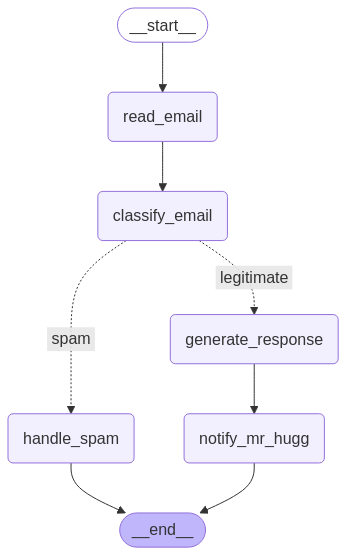

In [30]:

display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [31]:
pip install langgraph langchain_openai Pillow base64 langchain_core

ERROR: Could not find a version that satisfies the requirement base64 (from versions: none)
ERROR: No matching distribution found for base64


In [32]:
import base64
from typing import List, TypedDict, Annotated, Optional
from langchain.schema import HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, SystemMessage
from langgraph.graph.message import add_messages
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

In [33]:
class AgentState(TypedDict):
    # The document provided
    input_file: Optional[str]  # Contains file path (PDF/PNG)
    messages: Annotated[list[AnyMessage], add_messages]

In [34]:
vision_llm = ChatOpenAI(model="gpt-4o")

def extract_text(img_path: str) -> str:
    """
    Extract text from an image file using a multimodal model.

    Master Wayne often leaves notes with his training regimen or meal plans.
    This allows me to properly analyze the contents.
    """
    all_text = ""
    try:
        # Read image and encode as base64
        with open(img_path, "rb") as image_file:
            image_bytes = image_file.read()

        image_base64 = base64.b64encode(image_bytes).decode("utf-8")

        # Prepare the prompt including the base64 image data
        message = [
            HumanMessage(
                content=[
                    {
                        "type": "text",
                        "text": (
                            "Extract all the text from this image. "
                            "Return only the extracted text, no explanations."
                        ),
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{image_base64}"
                        },
                    },
                ]
            )
        ]

        # Call the vision-capable model
        response = vision_llm.invoke(message)

        # Append extracted text
        all_text += response.content + "\n\n"

        return all_text.strip()
    except Exception as e:
        # A butler should handle errors gracefully
        error_msg = f"Error extracting text: {str(e)}"
        print(error_msg)
        return ""

def divide(a: int, b: int) -> float:
    """Divide a and b - for Master Wayne's occasional calculations."""
    return a / b

# Equip the butler with tools
tools = [
    divide,
    extract_text
]

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [35]:
def assistant(state: AgentState):
    # System message
    textual_description_of_tool="""
extract_text(img_path: str) -> str:
    Extract text from an image file using a multimodal model.

    Args:
        img_path: A local image file path (strings).

    Returns:
        A single string containing the concatenated text extracted from each image.
divide(a: int, b: int) -> float:
    Divide a and b
"""
    image=state["input_file"]
    sys_msg = SystemMessage(content=f"You are an helpful butler named Alfred that serves Mr. Wayne and Batman. You can analyse documents and run computations with provided tools:\n{textual_description_of_tool} \n You have access to some optional images. Currently the loaded image is: {image}")

    return {
        "messages": [llm_with_tools.invoke([sys_msg] + state["messages"])],
        "input_file": state["input_file"]
    }

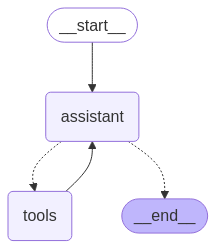

In [36]:
## The graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message requires a tool, route to tools
    # Otherwise, provide a direct response
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show the butler's thought process
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/unit2/LangGraph/Agent.png

In [38]:
messages = [HumanMessage(content="Divide 6790 by 5")]
messages = react_graph.invoke({"messages": messages, "input_file": None})


{'input_file': None, 'messages': [HumanMessage(content='Divide 6790 by 5', additional_kwargs={}, response_metadata={}, id='b8d8f93a-82f0-4414-a388-2ff506b2b1bc'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_OTUKDbpNHktho8wlDGsDsJF8', 'function': {'arguments': '{"a":6790,"b":5}', 'name': 'divide'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 224, 'total_tokens': 243, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_898ac29719', 'id': 'chatcmpl-BJ2WEd7hOuHetjKmBPDyGzgtXNMcf', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-922b97b3-7a92-4f38-b438-676076f1ecb4-0', tool_calls=[{'name': 'divide', 'args': {'a': 6790, 'b': 5}, 'id': 'call_OTUKDbpNHktho8wlDGsDsJF8', 'type':

In [39]:
print(messages)

{'input_file': None, 'messages': [HumanMessage(content='Divide 6790 by 5', additional_kwargs={}, response_metadata={}, id='b8d8f93a-82f0-4414-a388-2ff506b2b1bc'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_OTUKDbpNHktho8wlDGsDsJF8', 'function': {'arguments': '{"a":6790,"b":5}', 'name': 'divide'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 224, 'total_tokens': 243, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_898ac29719', 'id': 'chatcmpl-BJ2WEd7hOuHetjKmBPDyGzgtXNMcf', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-922b97b3-7a92-4f38-b438-676076f1ecb4-0', tool_calls=[{'name': 'divide', 'args': {'a': 6790, 'b': 5}, 'id': 'call_OTUKDbpNHktho8wlDGsDsJF8', 'type':

In [45]:
!wget https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/unit2/LangGraph/Batman_training_and_meals.png -O Batman_training_and_meals.png

--2025-04-05 18:35:17--  https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/unit2/LangGraph/Batman_training_and_meals.png
Resolving huggingface.co (huggingface.co)... 18.164.174.17, 18.164.174.23, 18.164.174.118, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.17|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/45/f4/45f48d5b3577034b76ee728dfe60afca3d0aa70790fda3e706eeb9276d8d5331/78e30a02cada412f2899312dfef9a6f6ba5c4cdae987305ecaeaa23565b68180?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27Batman_training_and_meals.png%3B+filename%3D%22Batman_training_and_meals.png%22%3B&response-content-type=image%2Fpng&Expires=1743881718&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0Mzg4MTcxOH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzQ1L2Y0LzQ1ZjQ4ZDViMzU3NzAzNGI3NmVlNzI4ZGZlNjBhZmNhM2QwYWE3MDc5MGZkYTNlNzA2ZWViOTI3NmQ4Z

In [46]:

messages = [HumanMessage(content="According to the note provided by Mr. Wayne in the provided images. What's the list of items I should buy for the dinner menu?")]
messages = react_graph.invoke({"messages": messages, "input_file": "Batman_training_and_meals.png"})

In [47]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

According to the note provided by Mr. Wayne in the provided images. What's the list of items I should buy for the dinner menu?
================================== Ai Message ==================================
Tool Calls:
  extract_text (call_HbJJSuCT0tFsVmWQdYoayVTl)
 Call ID: call_HbJJSuCT0tFsVmWQdYoayVTl
  Args:
    img_path: Batman_training_and_meals.png
================================= Tool Message =================================
Name: extract_text

TRAINING SCHEDULE  
For the week of 2/20-2/26  
  
SUNDAY 2/20  
MORNING  
30 minute jog  
30 minute meditation  
  
EVENING   
clean and jerk lifts—3 reps/8 sets, 262 lbs.  
5 sets metabolic conditioning:  
16 kettlebell swings  
12 pull-ups  
30 minutes flexibility  
30 minutes sparring  
  
MONDAY 2/21  
MORNING  
30 minute jog  
30 minutes traditional kata (focus on Japanese forms)  
  
EVENING   
5 sets 20 foot rope climb  
30 minutes gymnastics (wo